## Deep Learning Assignment-4
  **Name: Sanyam Kaul**  
  **Roll Number - CS23MTECH14011**  

  ---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Loading dataset:**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:02<00:00, 3311052.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 417527.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4538382.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3572867.36it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Q1

**Utility functions:**

In [5]:
def plot_reconstruction(reconstructions):
  for i, (output, target) in enumerate(reconstructions):
        output = output.view(-1, 1, 28, 28).cpu().numpy()
        target = target.view(-1, 1, 28, 28).cpu().numpy()
        plt.figure(figsize=(20, 4))
        for j in range(10):
            plt.subplot(2, 10, j + 1)
            plt.imshow(output[j][0], cmap='gray')
            plt.title('Reconstruction')
            plt.axis('off')
        for j in range(10):
            plt.subplot(2, 10, j + 11)
            plt.imshow(target[j][0], cmap='gray')
            plt.title('Original')
            plt.axis('off')
        plt.show()
        break

In [6]:
def plot_autoencoder_loss(train_losses, latent_dim):
  epochs = range(1, len(train_losses) + 1)
  plt.plot(epochs, train_losses, label=f'Training Loss (Latent Dimension: {latent_dim})')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Autoencoder Training Loss')
  plt.legend()
  plt.show()

In [7]:
def interpolate_latent_space(model, image1, image2, num_steps=10):
    model.eval()
    with torch.no_grad():
        image1 = image1.view(1, -1).to(device)
        image2 = image2.view(1, -1).to(device)
        latent1 = model.encoder(image1)
        latent2 = model.encoder(image2)

        interpolations = []
        for alpha in torch.linspace(0, 1, num_steps):
            interpolated_latent = alpha * latent1 + (1 - alpha) * latent2
            interpolations.append(interpolated_latent)

        reconstructed_images = []
        for interpolated_latent in interpolations:
            output = model.decoder(interpolated_latent)
            reconstructed_images.append(output.view(1, 28, 28))

    return reconstructed_images

In [8]:
def plot_original_images(image1, image2):
    plt.figure(figsize=(5, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(image2[0], cmap='gray')
    plt.title('Original Image 1')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image1[0], cmap='gray')
    plt.title('Original Image 2')
    plt.axis('off')
    plt.show()

In [9]:
def plot_interpolations():
  plt.figure(figsize=(20, 4))
  for j, reconstructed_image in enumerate(reconstructions):
    plt.subplot(1, 10, j + 1)
    plt.imshow(reconstructed_image.cpu().numpy().squeeze(), cmap='gray')
    plt.title(f'Interpolation {j+1}')
    plt.axis('off')
  plt.show()

In [10]:
pairs = [(train_dataset[10][0], train_dataset[20][0]),
         (train_dataset[100][0], train_dataset[200][0]),
         (train_dataset[500][0], train_dataset[1000][0]),
         (train_dataset[1000][0], train_dataset[1500][0]),
         (train_dataset[2000][0], train_dataset[2500][0])]

**Implementing Autoencoders:**

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
def train_autoencoder(model, train_loader, optimizer, criterion, num_epochs=10):
    train_losses = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as pbar:
            for batch in train_loader:
                images, _ = batch
                images = images.view(images.size(0), -1)
                images = images.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.update(1)
        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
    return train_losses

In [13]:
def test_autoencoder(model, test_loader, criterion):
    test_losses = []
    model.eval()
    with torch.no_grad():
        total_loss = 0
        reconstructions = []
        for batch in tqdm(test_loader, desc="Testing", unit='batch'):
            images, _ = batch
            images = images.view(images.size(0), -1)
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
            if len(reconstructions) < 10:
                reconstructions.append((outputs, images))

        test_loss = total_loss / len(test_loader.dataset)
        test_losses.append(test_loss)
    return test_losses, reconstructions

In [14]:
def train_model(latent_dim):
    print(f"\nTraining autoencoder with latent dimension: {latent_dim}")
    model = Autoencoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_losses = train_autoencoder(model, train_loader, optimizer, criterion)
    test_losses, reconstructions = test_autoencoder(model, test_loader, criterion)

    plot_autoencoder_loss(train_losses, latent_dim)
    plot_reconstruction(reconstructions)

    print(f"Train Reconstruction Error (Latent Dimension: {latent_dim}): {train_losses[-1]}")
    print(f"Test Reconstruction Error (Latent Dimension: {latent_dim}): {test_losses[-1]}")

    return model

**Autoencoder with 16D latent space:**


Training autoencoder with latent dimension: 16


Epoch 1/10: 100%|██████████| 469/469 [00:09<00:00, 51.89batch/s]


Epoch [1/10], Loss: 0.0004


Epoch 2/10: 100%|██████████| 469/469 [00:07<00:00, 64.73batch/s]


Epoch [2/10], Loss: 0.0002


Epoch 3/10: 100%|██████████| 469/469 [00:08<00:00, 57.38batch/s]


Epoch [3/10], Loss: 0.0002


Epoch 4/10: 100%|██████████| 469/469 [00:08<00:00, 57.55batch/s]


Epoch [4/10], Loss: 0.0001


Epoch 5/10: 100%|██████████| 469/469 [00:07<00:00, 64.93batch/s]


Epoch [5/10], Loss: 0.0001


Epoch 6/10: 100%|██████████| 469/469 [00:08<00:00, 57.80batch/s]


Epoch [6/10], Loss: 0.0001


Epoch 7/10: 100%|██████████| 469/469 [00:07<00:00, 61.95batch/s]


Epoch [7/10], Loss: 0.0001


Epoch 8/10: 100%|██████████| 469/469 [00:08<00:00, 56.96batch/s]


Epoch [8/10], Loss: 0.0001


Epoch 9/10: 100%|██████████| 469/469 [00:08<00:00, 56.00batch/s]


Epoch [9/10], Loss: 0.0001


Epoch 10/10: 100%|██████████| 469/469 [00:07<00:00, 64.77batch/s]


Epoch [10/10], Loss: 0.0001


Testing: 100%|██████████| 79/79 [00:01<00:00, 74.72batch/s]


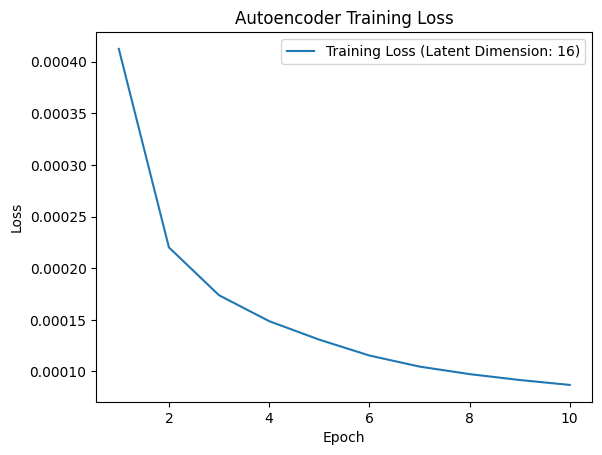

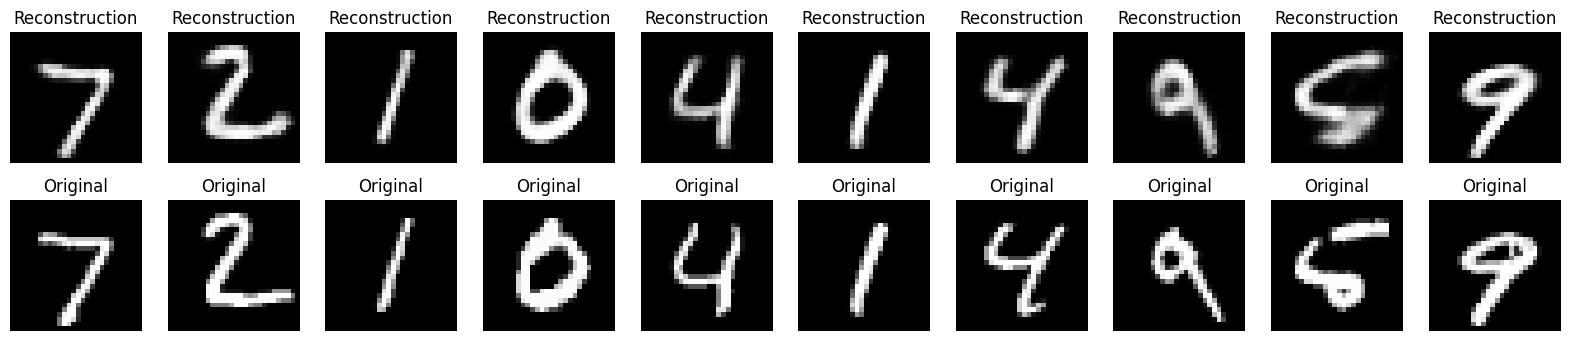

Train Reconstruction Error (Latent Dimension: 16): 8.699657581746578e-05
Test Reconstruction Error (Latent Dimension: 16): 8.652148717083036e-05


In [15]:
model16d = train_model(16)

**Learning Autoencoder with 32D latent space:**


Training autoencoder with latent dimension: 32


Epoch 1/10: 100%|██████████| 469/469 [00:08<00:00, 53.89batch/s]


Epoch [1/10], Loss: 0.0004


Epoch 2/10: 100%|██████████| 469/469 [00:08<00:00, 55.96batch/s]


Epoch [2/10], Loss: 0.0002


Epoch 3/10: 100%|██████████| 469/469 [00:07<00:00, 64.50batch/s]


Epoch [3/10], Loss: 0.0002


Epoch 4/10: 100%|██████████| 469/469 [00:08<00:00, 57.15batch/s]


Epoch [4/10], Loss: 0.0001


Epoch 5/10: 100%|██████████| 469/469 [00:08<00:00, 56.61batch/s]


Epoch [5/10], Loss: 0.0001


Epoch 6/10: 100%|██████████| 469/469 [00:07<00:00, 63.88batch/s]


Epoch [6/10], Loss: 0.0001


Epoch 7/10: 100%|██████████| 469/469 [00:08<00:00, 57.29batch/s]


Epoch [7/10], Loss: 0.0001


Epoch 8/10: 100%|██████████| 469/469 [00:07<00:00, 62.19batch/s]


Epoch [8/10], Loss: 0.0001


Epoch 9/10: 100%|██████████| 469/469 [00:08<00:00, 58.62batch/s]


Epoch [9/10], Loss: 0.0001


Epoch 10/10: 100%|██████████| 469/469 [00:08<00:00, 56.56batch/s]


Epoch [10/10], Loss: 0.0001


Testing: 100%|██████████| 79/79 [00:01<00:00, 76.33batch/s]


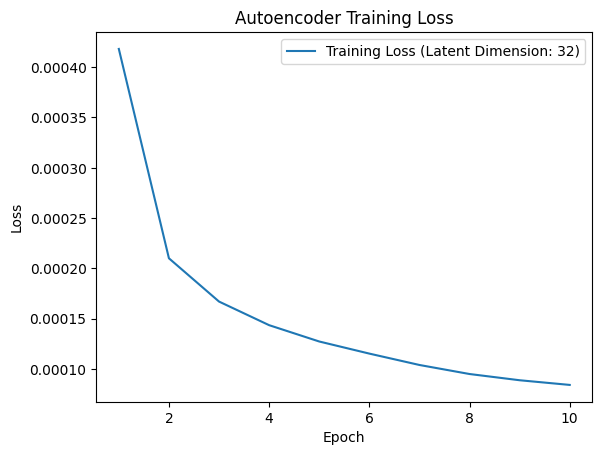

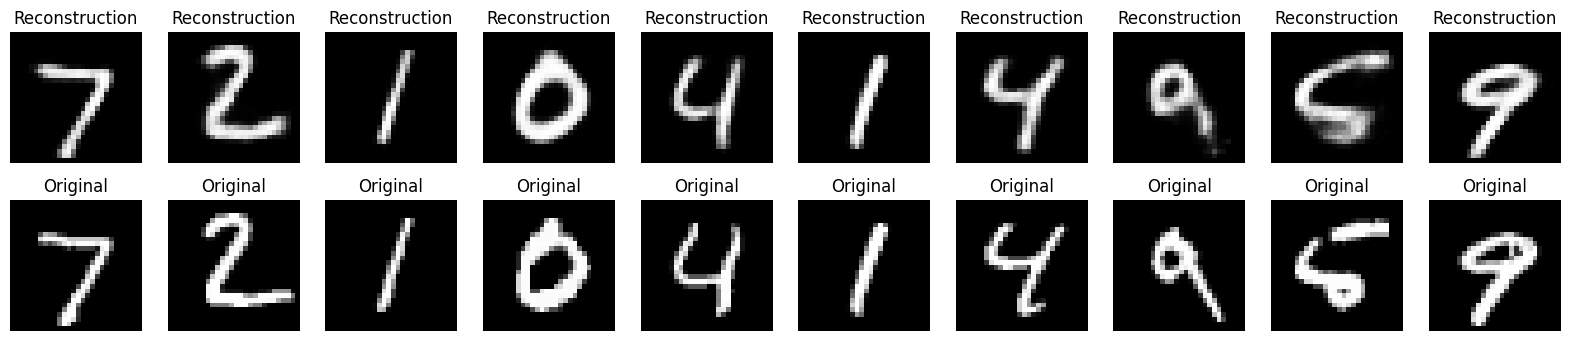

Train Reconstruction Error (Latent Dimension: 32): 8.42695394375672e-05
Test Reconstruction Error (Latent Dimension: 32): 8.448611674830318e-05


In [16]:
model32d = train_model(32)

**Learning Autoencoder with 64D latent space:**


Training autoencoder with latent dimension: 64


Epoch 1/10: 100%|██████████| 469/469 [00:07<00:00, 60.69batch/s]


Epoch [1/10], Loss: 0.0004


Epoch 2/10: 100%|██████████| 469/469 [00:08<00:00, 58.57batch/s]


Epoch [2/10], Loss: 0.0002


Epoch 3/10: 100%|██████████| 469/469 [00:08<00:00, 53.30batch/s]


Epoch [3/10], Loss: 0.0002


Epoch 4/10: 100%|██████████| 469/469 [00:07<00:00, 58.85batch/s]


Epoch [4/10], Loss: 0.0001


Epoch 5/10: 100%|██████████| 469/469 [00:08<00:00, 58.09batch/s]


Epoch [5/10], Loss: 0.0001


Epoch 6/10: 100%|██████████| 469/469 [00:08<00:00, 56.58batch/s]


Epoch [6/10], Loss: 0.0001


Epoch 7/10: 100%|██████████| 469/469 [00:07<00:00, 63.35batch/s]


Epoch [7/10], Loss: 0.0001


Epoch 8/10: 100%|██████████| 469/469 [00:08<00:00, 56.79batch/s]


Epoch [8/10], Loss: 0.0001


Epoch 9/10: 100%|██████████| 469/469 [00:07<00:00, 60.04batch/s]


Epoch [9/10], Loss: 0.0001


Epoch 10/10: 100%|██████████| 469/469 [00:07<00:00, 59.42batch/s]


Epoch [10/10], Loss: 0.0001


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.01batch/s]


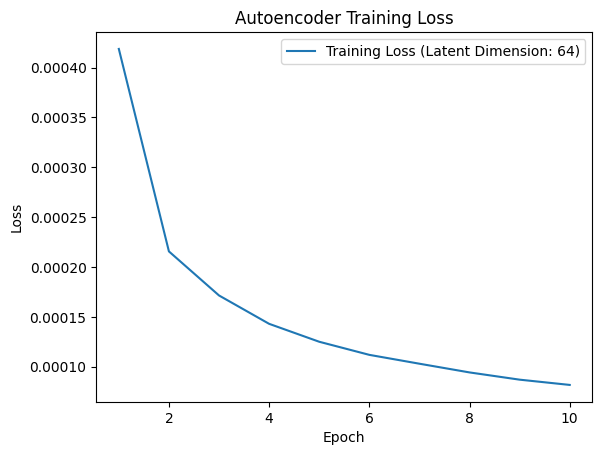

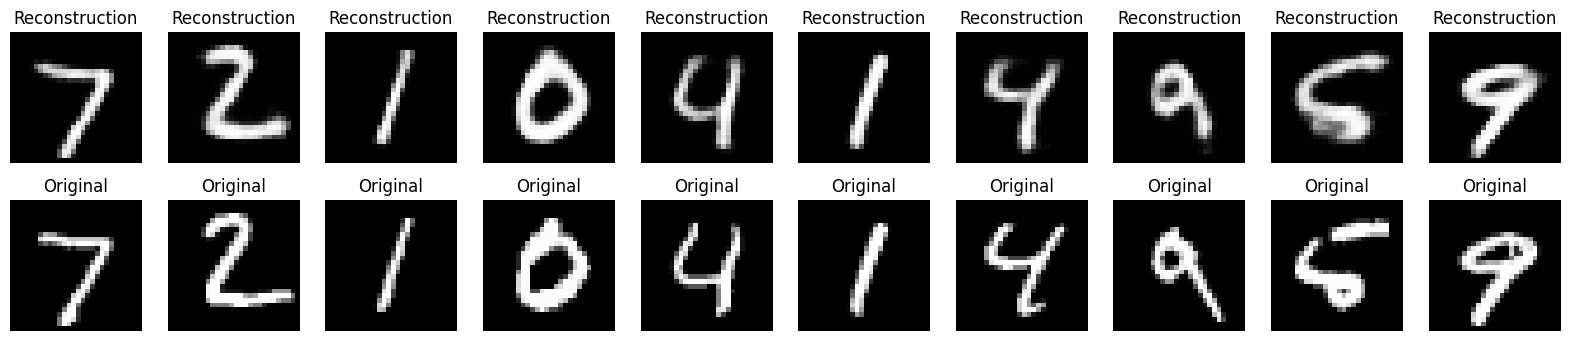

Train Reconstruction Error (Latent Dimension: 64): 8.16637290486445e-05
Test Reconstruction Error (Latent Dimension: 64): 8.372979904524982e-05


In [17]:
model64d = train_model(64)

**Vizualizing interpolations from 16D autoencoder:**

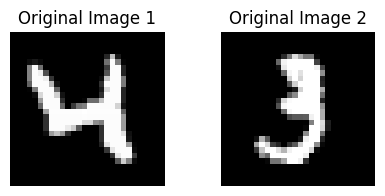

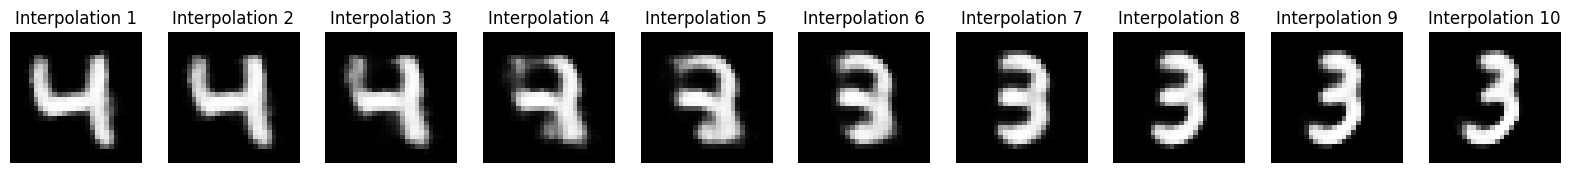

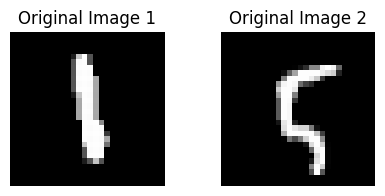

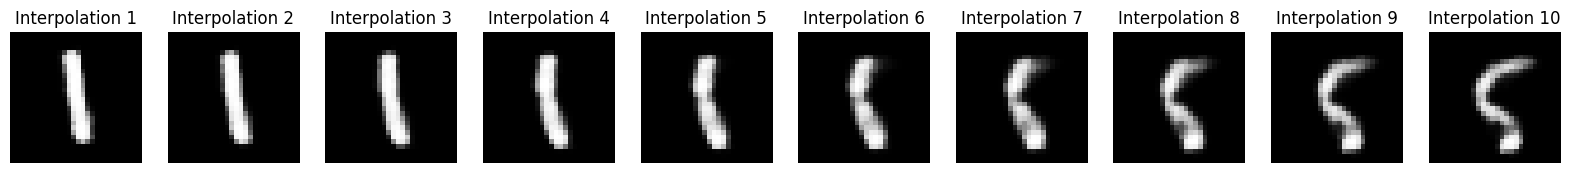

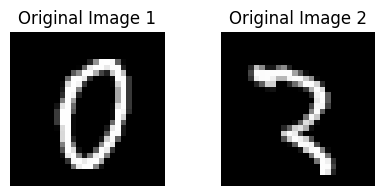

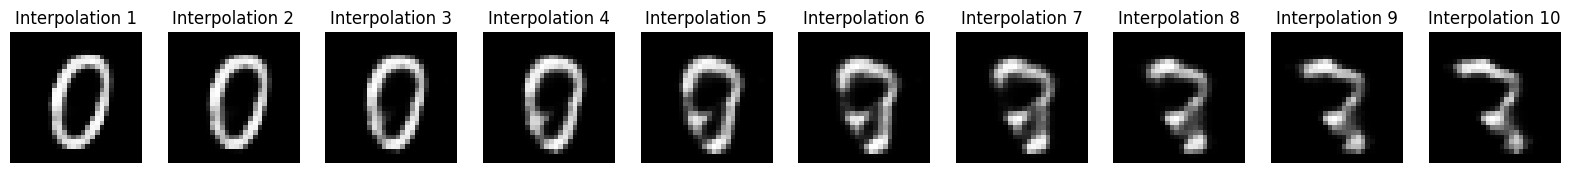

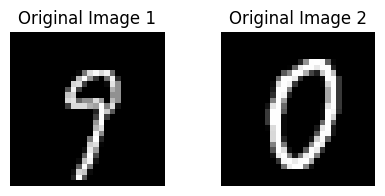

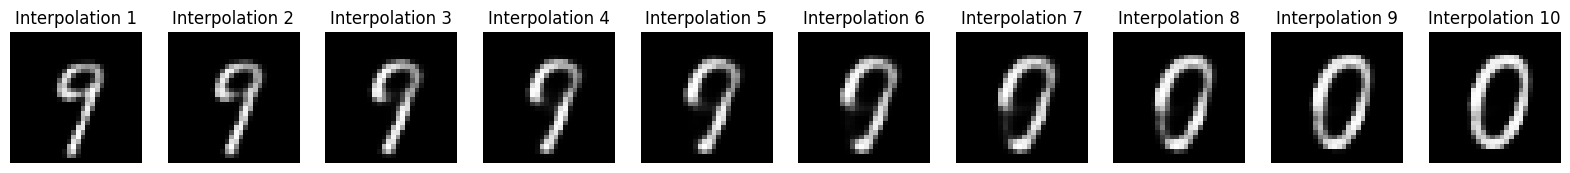

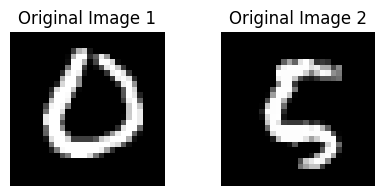

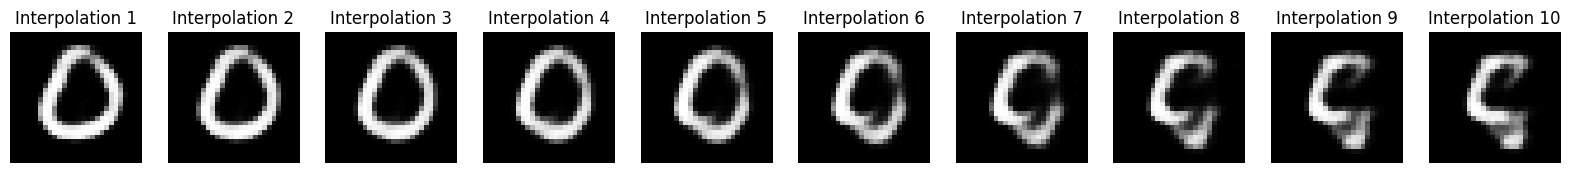

In [18]:
for i, (image1, image2) in enumerate(pairs):
    plot_original_images(image1, image2)
    reconstructions = interpolate_latent_space(model16d, image1, image2, num_steps=10)
    plot_interpolations()

**Vizualizing interpolations from 32D autoencoder:**

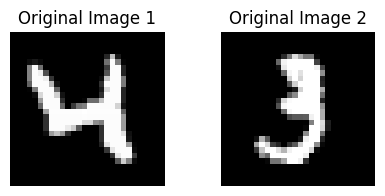

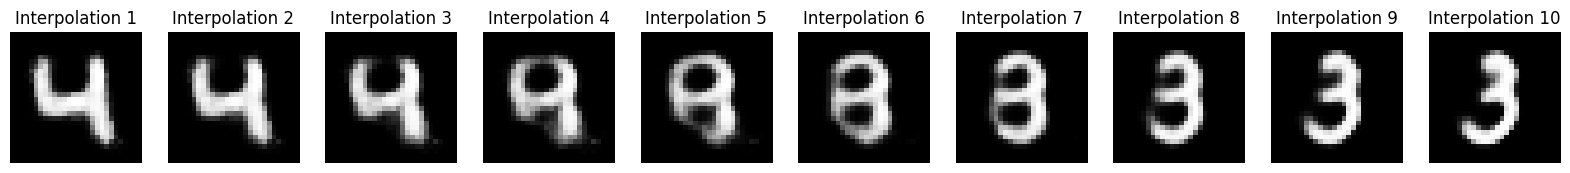

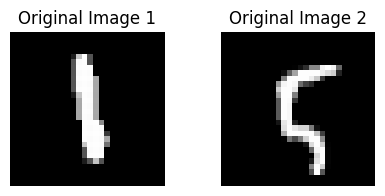

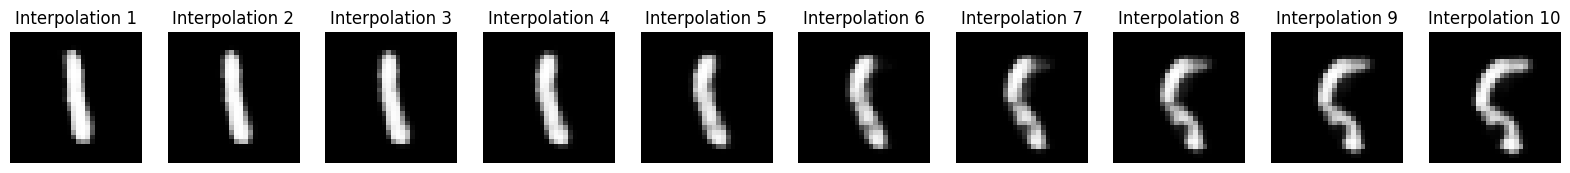

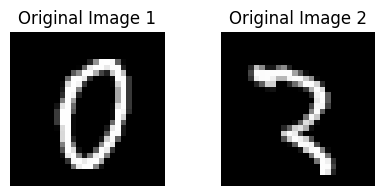

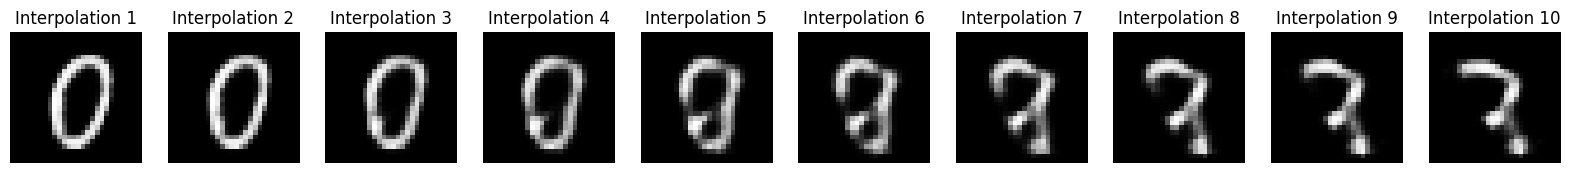

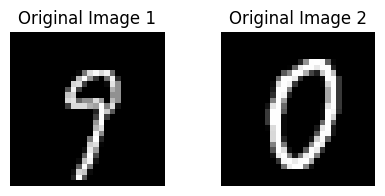

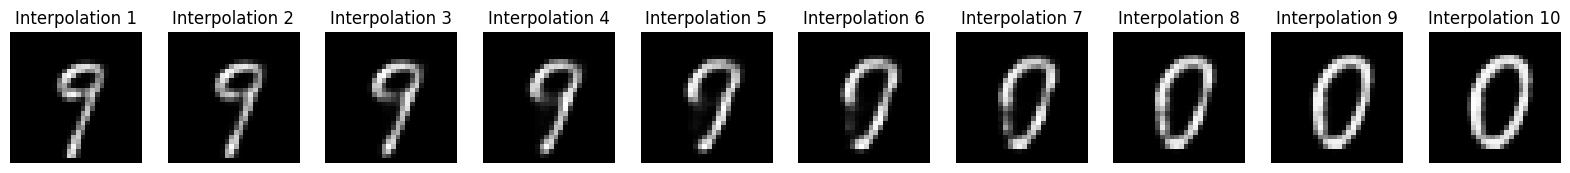

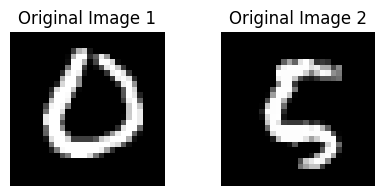

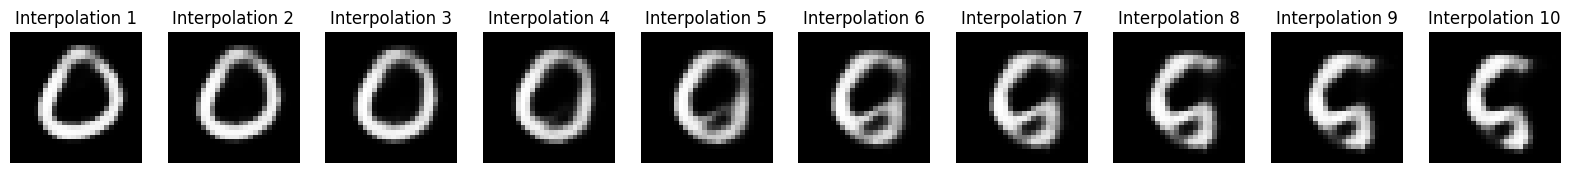

In [19]:
for i, (image1, image2) in enumerate(pairs):
    plot_original_images(image1, image2)
    reconstructions = interpolate_latent_space(model32d, image1, image2, num_steps=10)
    plot_interpolations()

**Vizualizing interpolations from 64D autoencoder:**

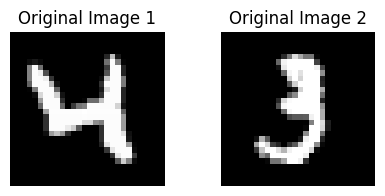

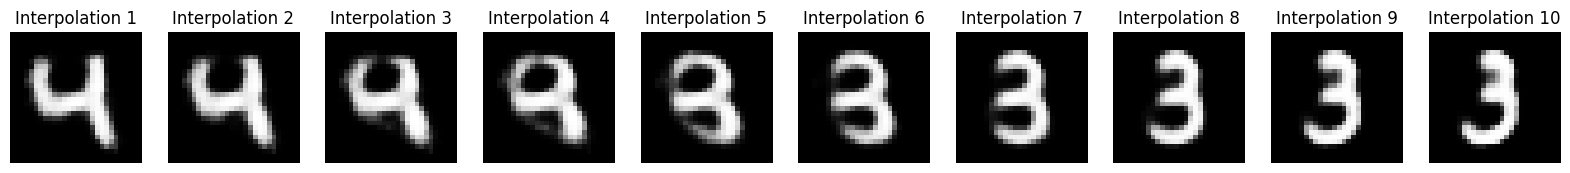

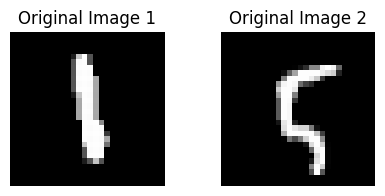

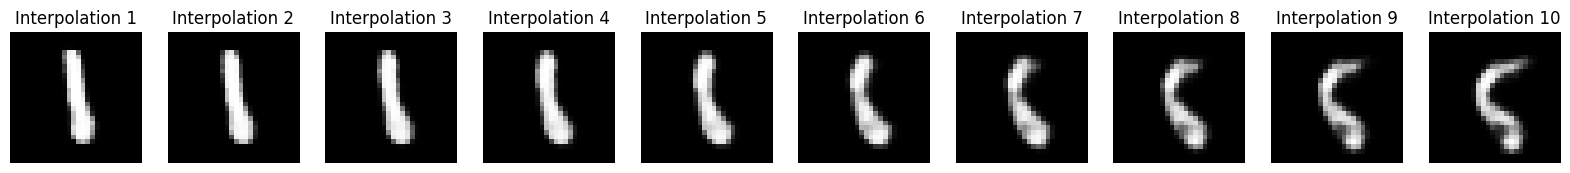

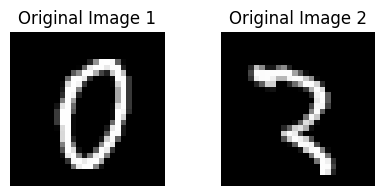

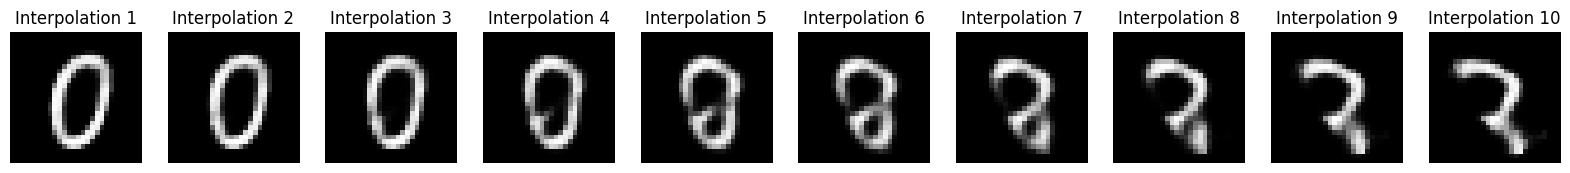

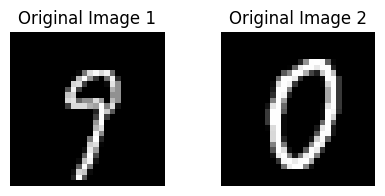

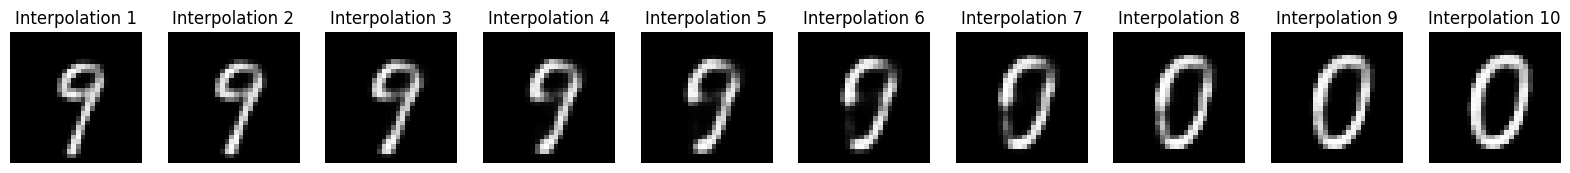

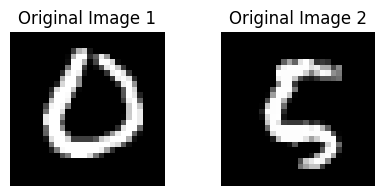

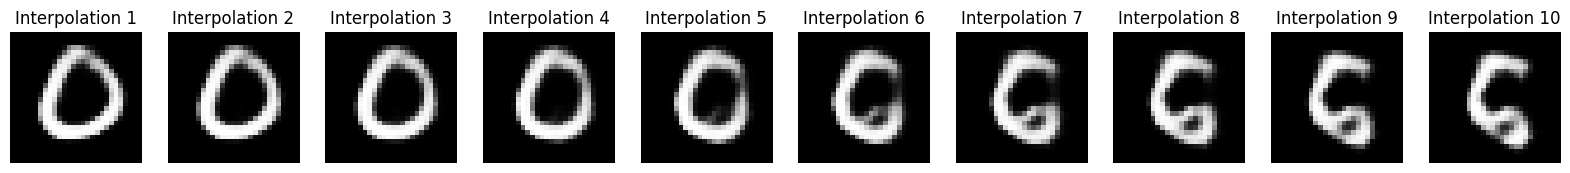

In [20]:
for i, (image1, image2) in enumerate(pairs):
    plot_original_images(image1, image2)
    reconstructions = interpolate_latent_space(model64d, image1, image2, num_steps=10)
    plot_interpolations()

---  
## Q2

**Utility functions:**

In [21]:
def plot_vae_loss(train_losses):
  plt.plot(range(1, len(train_losses) + 1), train_losses)
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('VAE Training Loss')
  plt.show()

In [22]:
def generate_images_vae(model, num_images=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        generated_images = model.decode(z).view(-1, 1, 28, 28).cpu().numpy()
    return generated_images

In [23]:
def plot_generated_images(generated_images):
  plt.figure(figsize=(10, 10))
  for i in range(len(generated_images)):
      plt.subplot(8, 8, i + 1)
      plt.imshow(generated_images[i][0], cmap='gray')
      plt.axis('off')
  plt.show()

**Implementing VAE:**

In [24]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256,784),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [25]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 784))
    kl_div_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div_loss

In [26]:
def train_vae(model, train_loader, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as pbar:
            for batch in train_loader:
                images, _ = batch
                images = images.view(images.size(0), -1)
                images = images.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(images)
                loss = vae_loss(recon_batch, images, mu, logvar)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.update(1)
        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")
    return train_losses

**Learning model:**

In [27]:
latent_dim = 16
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1/100: 100%|██████████| 469/469 [00:08<00:00, 53.51batch/s]


Epoch [1/100], Loss: 203.0324


Epoch 2/100: 100%|██████████| 469/469 [00:07<00:00, 58.76batch/s]


Epoch [2/100], Loss: 157.7075


Epoch 3/100: 100%|██████████| 469/469 [00:08<00:00, 56.57batch/s]


Epoch [3/100], Loss: 138.1058


Epoch 4/100: 100%|██████████| 469/469 [00:08<00:00, 54.69batch/s]


Epoch [4/100], Loss: 129.6929


Epoch 5/100: 100%|██████████| 469/469 [00:07<00:00, 60.87batch/s]


Epoch [5/100], Loss: 125.6045


Epoch 6/100: 100%|██████████| 469/469 [00:08<00:00, 54.87batch/s]


Epoch [6/100], Loss: 123.0574


Epoch 7/100: 100%|██████████| 469/469 [00:08<00:00, 55.48batch/s]


Epoch [7/100], Loss: 121.2716


Epoch 8/100: 100%|██████████| 469/469 [00:07<00:00, 60.46batch/s]


Epoch [8/100], Loss: 119.7233


Epoch 9/100: 100%|██████████| 469/469 [00:08<00:00, 54.96batch/s]


Epoch [9/100], Loss: 118.5589


Epoch 10/100: 100%|██████████| 469/469 [00:08<00:00, 53.67batch/s]


Epoch [10/100], Loss: 117.5621


Epoch 11/100: 100%|██████████| 469/469 [00:07<00:00, 62.23batch/s]


Epoch [11/100], Loss: 116.7381


Epoch 12/100: 100%|██████████| 469/469 [00:08<00:00, 55.08batch/s]


Epoch [12/100], Loss: 116.0365


Epoch 13/100: 100%|██████████| 469/469 [00:08<00:00, 57.97batch/s]


Epoch [13/100], Loss: 115.4182


Epoch 14/100: 100%|██████████| 469/469 [00:08<00:00, 57.72batch/s]


Epoch [14/100], Loss: 114.8911


Epoch 15/100: 100%|██████████| 469/469 [00:08<00:00, 56.03batch/s]


Epoch [15/100], Loss: 114.3770


Epoch 16/100: 100%|██████████| 469/469 [00:07<00:00, 60.72batch/s]


Epoch [16/100], Loss: 113.9651


Epoch 17/100: 100%|██████████| 469/469 [00:08<00:00, 52.31batch/s]


Epoch [17/100], Loss: 113.6034


Epoch 18/100: 100%|██████████| 469/469 [00:09<00:00, 48.95batch/s]


Epoch [18/100], Loss: 113.2786


Epoch 19/100: 100%|██████████| 469/469 [00:07<00:00, 59.22batch/s]


Epoch [19/100], Loss: 112.9104


Epoch 20/100: 100%|██████████| 469/469 [00:08<00:00, 55.28batch/s]


Epoch [20/100], Loss: 112.6592


Epoch 21/100: 100%|██████████| 469/469 [00:08<00:00, 53.96batch/s]


Epoch [21/100], Loss: 112.3541


Epoch 22/100: 100%|██████████| 469/469 [00:07<00:00, 60.99batch/s]


Epoch [22/100], Loss: 112.1344


Epoch 23/100: 100%|██████████| 469/469 [00:08<00:00, 54.74batch/s]


Epoch [23/100], Loss: 111.8858


Epoch 24/100: 100%|██████████| 469/469 [00:08<00:00, 55.03batch/s]


Epoch [24/100], Loss: 111.6591


Epoch 25/100: 100%|██████████| 469/469 [00:07<00:00, 61.68batch/s]


Epoch [25/100], Loss: 111.4234


Epoch 26/100: 100%|██████████| 469/469 [00:08<00:00, 54.48batch/s]


Epoch [26/100], Loss: 111.2849


Epoch 27/100: 100%|██████████| 469/469 [00:08<00:00, 53.84batch/s]


Epoch [27/100], Loss: 111.0581


Epoch 28/100: 100%|██████████| 469/469 [00:07<00:00, 61.22batch/s]


Epoch [28/100], Loss: 110.9247


Epoch 29/100: 100%|██████████| 469/469 [00:08<00:00, 54.95batch/s]


Epoch [29/100], Loss: 110.7425


Epoch 30/100: 100%|██████████| 469/469 [00:08<00:00, 58.14batch/s]


Epoch [30/100], Loss: 110.5387


Epoch 31/100: 100%|██████████| 469/469 [00:08<00:00, 58.31batch/s]


Epoch [31/100], Loss: 110.4394


Epoch 32/100: 100%|██████████| 469/469 [00:08<00:00, 54.54batch/s]


Epoch [32/100], Loss: 110.3262


Epoch 33/100: 100%|██████████| 469/469 [00:07<00:00, 61.55batch/s]


Epoch [33/100], Loss: 110.1422


Epoch 34/100: 100%|██████████| 469/469 [00:08<00:00, 55.09batch/s]


Epoch [34/100], Loss: 110.0207


Epoch 35/100: 100%|██████████| 469/469 [00:08<00:00, 54.69batch/s]


Epoch [35/100], Loss: 109.9447


Epoch 36/100: 100%|██████████| 469/469 [00:07<00:00, 61.26batch/s]


Epoch [36/100], Loss: 109.8228


Epoch 37/100: 100%|██████████| 469/469 [00:08<00:00, 55.21batch/s]


Epoch [37/100], Loss: 109.6597


Epoch 38/100: 100%|██████████| 469/469 [00:08<00:00, 54.28batch/s]


Epoch [38/100], Loss: 109.5819


Epoch 39/100: 100%|██████████| 469/469 [00:07<00:00, 61.31batch/s]


Epoch [39/100], Loss: 109.4535


Epoch 40/100: 100%|██████████| 469/469 [00:08<00:00, 54.57batch/s]


Epoch [40/100], Loss: 109.3330


Epoch 41/100: 100%|██████████| 469/469 [00:08<00:00, 56.97batch/s]


Epoch [41/100], Loss: 109.2378


Epoch 42/100: 100%|██████████| 469/469 [00:08<00:00, 58.54batch/s]


Epoch [42/100], Loss: 109.1210


Epoch 43/100: 100%|██████████| 469/469 [00:09<00:00, 49.49batch/s]


Epoch [43/100], Loss: 109.0635


Epoch 44/100: 100%|██████████| 469/469 [00:08<00:00, 58.39batch/s]


Epoch [44/100], Loss: 108.9727


Epoch 45/100: 100%|██████████| 469/469 [00:08<00:00, 58.16batch/s]


Epoch [45/100], Loss: 108.8649


Epoch 46/100: 100%|██████████| 469/469 [00:08<00:00, 55.44batch/s]


Epoch [46/100], Loss: 108.7950


Epoch 47/100: 100%|██████████| 469/469 [00:07<00:00, 60.68batch/s]


Epoch [47/100], Loss: 108.7304


Epoch 48/100: 100%|██████████| 469/469 [00:08<00:00, 54.96batch/s]


Epoch [48/100], Loss: 108.6097


Epoch 49/100: 100%|██████████| 469/469 [00:08<00:00, 54.37batch/s]


Epoch [49/100], Loss: 108.5694


Epoch 50/100: 100%|██████████| 469/469 [00:07<00:00, 61.87batch/s]


Epoch [50/100], Loss: 108.4663


Epoch 51/100: 100%|██████████| 469/469 [00:08<00:00, 54.56batch/s]


Epoch [51/100], Loss: 108.3745


Epoch 52/100: 100%|██████████| 469/469 [00:08<00:00, 54.47batch/s]


Epoch [52/100], Loss: 108.3524


Epoch 53/100: 100%|██████████| 469/469 [00:07<00:00, 62.18batch/s]


Epoch [53/100], Loss: 108.2675


Epoch 54/100: 100%|██████████| 469/469 [00:08<00:00, 55.04batch/s]


Epoch [54/100], Loss: 108.1578


Epoch 55/100: 100%|██████████| 469/469 [00:08<00:00, 57.39batch/s]


Epoch [55/100], Loss: 108.1822


Epoch 56/100: 100%|██████████| 469/469 [00:08<00:00, 58.45batch/s]


Epoch [56/100], Loss: 108.0592


Epoch 57/100: 100%|██████████| 469/469 [00:08<00:00, 54.66batch/s]


Epoch [57/100], Loss: 107.9592


Epoch 58/100: 100%|██████████| 469/469 [00:08<00:00, 58.16batch/s]


Epoch [58/100], Loss: 107.9035


Epoch 59/100: 100%|██████████| 469/469 [00:08<00:00, 55.51batch/s]


Epoch [59/100], Loss: 107.9128


Epoch 60/100: 100%|██████████| 469/469 [00:08<00:00, 53.45batch/s]


Epoch [60/100], Loss: 107.8057


Epoch 61/100: 100%|██████████| 469/469 [00:07<00:00, 60.37batch/s]


Epoch [61/100], Loss: 107.7623


Epoch 62/100: 100%|██████████| 469/469 [00:08<00:00, 54.77batch/s]


Epoch [62/100], Loss: 107.6964


Epoch 63/100: 100%|██████████| 469/469 [00:08<00:00, 54.67batch/s]


Epoch [63/100], Loss: 107.6802


Epoch 64/100: 100%|██████████| 469/469 [00:07<00:00, 60.52batch/s]


Epoch [64/100], Loss: 107.5595


Epoch 65/100: 100%|██████████| 469/469 [00:08<00:00, 54.82batch/s]


Epoch [65/100], Loss: 107.5196


Epoch 66/100: 100%|██████████| 469/469 [00:08<00:00, 54.89batch/s]


Epoch [66/100], Loss: 107.4959


Epoch 67/100: 100%|██████████| 469/469 [00:07<00:00, 61.14batch/s]


Epoch [67/100], Loss: 107.3997


Epoch 68/100: 100%|██████████| 469/469 [00:09<00:00, 48.35batch/s]


Epoch [68/100], Loss: 107.4333


Epoch 69/100: 100%|██████████| 469/469 [00:08<00:00, 56.93batch/s]


Epoch [69/100], Loss: 107.3200


Epoch 70/100: 100%|██████████| 469/469 [00:07<00:00, 58.89batch/s]


Epoch [70/100], Loss: 107.2604


Epoch 71/100: 100%|██████████| 469/469 [00:08<00:00, 54.56batch/s]


Epoch [71/100], Loss: 107.2902


Epoch 72/100: 100%|██████████| 469/469 [00:07<00:00, 60.59batch/s]


Epoch [72/100], Loss: 107.2077


Epoch 73/100: 100%|██████████| 469/469 [00:08<00:00, 56.11batch/s]


Epoch [73/100], Loss: 107.1191


Epoch 74/100: 100%|██████████| 469/469 [00:08<00:00, 54.68batch/s]


Epoch [74/100], Loss: 107.1291


Epoch 75/100: 100%|██████████| 469/469 [00:07<00:00, 61.77batch/s]


Epoch [75/100], Loss: 107.0308


Epoch 76/100: 100%|██████████| 469/469 [00:08<00:00, 54.59batch/s]


Epoch [76/100], Loss: 107.0185


Epoch 77/100: 100%|██████████| 469/469 [00:08<00:00, 54.86batch/s]


Epoch [77/100], Loss: 107.0295


Epoch 78/100: 100%|██████████| 469/469 [00:07<00:00, 61.00batch/s]


Epoch [78/100], Loss: 106.9270


Epoch 79/100: 100%|██████████| 469/469 [00:08<00:00, 55.49batch/s]


Epoch [79/100], Loss: 106.9032


Epoch 80/100: 100%|██████████| 469/469 [00:08<00:00, 57.37batch/s]


Epoch [80/100], Loss: 106.8918


Epoch 81/100: 100%|██████████| 469/469 [00:07<00:00, 58.94batch/s]


Epoch [81/100], Loss: 106.8296


Epoch 82/100: 100%|██████████| 469/469 [00:08<00:00, 55.07batch/s]


Epoch [82/100], Loss: 106.8095


Epoch 83/100: 100%|██████████| 469/469 [00:07<00:00, 60.77batch/s]


Epoch [83/100], Loss: 106.7463


Epoch 84/100: 100%|██████████| 469/469 [00:08<00:00, 54.20batch/s]


Epoch [84/100], Loss: 106.7519


Epoch 85/100: 100%|██████████| 469/469 [00:08<00:00, 54.33batch/s]


Epoch [85/100], Loss: 106.7125


Epoch 86/100: 100%|██████████| 469/469 [00:07<00:00, 60.51batch/s]


Epoch [86/100], Loss: 106.6859


Epoch 87/100: 100%|██████████| 469/469 [00:08<00:00, 54.36batch/s]


Epoch [87/100], Loss: 106.6359


Epoch 88/100: 100%|██████████| 469/469 [00:08<00:00, 54.13batch/s]


Epoch [88/100], Loss: 106.5925


Epoch 89/100: 100%|██████████| 469/469 [00:07<00:00, 60.31batch/s]


Epoch [89/100], Loss: 106.5692


Epoch 90/100: 100%|██████████| 469/469 [00:08<00:00, 54.60batch/s]


Epoch [90/100], Loss: 106.5224


Epoch 91/100: 100%|██████████| 469/469 [00:08<00:00, 54.31batch/s]


Epoch [91/100], Loss: 106.5395


Epoch 92/100: 100%|██████████| 469/469 [00:07<00:00, 61.48batch/s]


Epoch [92/100], Loss: 106.4960


Epoch 93/100: 100%|██████████| 469/469 [00:09<00:00, 48.80batch/s]


Epoch [93/100], Loss: 106.4647


Epoch 94/100: 100%|██████████| 469/469 [00:08<00:00, 57.32batch/s]


Epoch [94/100], Loss: 106.4242


Epoch 95/100: 100%|██████████| 469/469 [00:07<00:00, 58.83batch/s]


Epoch [95/100], Loss: 106.4293


Epoch 96/100: 100%|██████████| 469/469 [00:08<00:00, 54.35batch/s]


Epoch [96/100], Loss: 106.3447


Epoch 97/100: 100%|██████████| 469/469 [00:07<00:00, 60.16batch/s]


Epoch [97/100], Loss: 106.3077


Epoch 98/100: 100%|██████████| 469/469 [00:08<00:00, 55.99batch/s]


Epoch [98/100], Loss: 106.2803


Epoch 99/100: 100%|██████████| 469/469 [00:08<00:00, 54.60batch/s]


Epoch [99/100], Loss: 106.2965


Epoch 100/100: 100%|██████████| 469/469 [00:07<00:00, 60.27batch/s]


Epoch [100/100], Loss: 106.2186


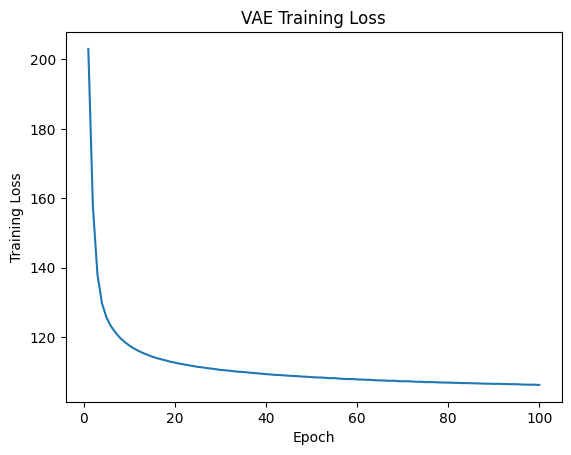

In [28]:
train_losses = train_vae(model, train_loader, optimizer, num_epochs=100)
plot_vae_loss(train_losses)

**Generating/plotting images from VAE of 16D latent space:**

In [29]:
generated_images = generate_images_vae(model)

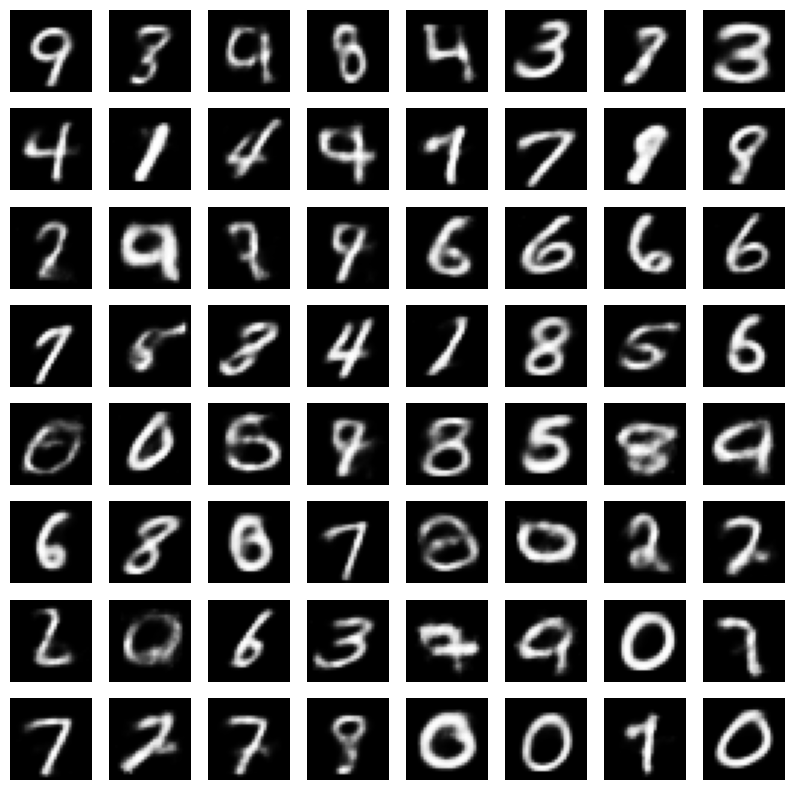

In [30]:
plot_generated_images(generated_images)